In [35]:
import sys
sys.path.append( '../utilities' )
from data_engine import DataEngine
from backtesting import Backtesting
import pandas as pd
import ta
import ccxt
import pandas_ta as pda

In [36]:
# pairList = pairJson['hitbtc2018']
pair = 'ETH/USDT'
timeframe = '1h'
startDate = '2017-01-01T00:00:00'

dataEngine = DataEngine(session=ccxt.binance(), path_to_data='./database/')

df = dataEngine.get_historical_from_db(pair, timeframe, startDate)

Successfully load 39586 candles for ETHUSDT


In [37]:
# -- Indicator variable --
trixLength = 9
trixSignal = 19
stochWindow = 14

# -- Drop all columns we do not need --
df.drop(columns=df.columns.difference(['open','high','low','close','volume']), inplace=True)

# -- Indicators, you can edit every value --
df['TRIX'] = ta.trend.ema_indicator(ta.trend.ema_indicator(ta.trend.ema_indicator(close=df['close'], window=trixLength), window=trixLength), window=trixLength)
df['TRIX_PCT'] = df["TRIX"].pct_change()*100
df['TRIX_SIGNAL'] = ta.trend.sma_indicator(df['TRIX_PCT'], trixSignal)
df['TRIX_HISTO'] = df['TRIX_PCT'] - df['TRIX_SIGNAL']
df['STOCH_RSI'] = ta.momentum.stochrsi(close=df['close'], window=stochWindow, smooth1=3, smooth2=3)

print("Indicators loaded 100%")
df

Indicators loaded 100%


,open,high,low,close,volume,TRIX,TRIX_PCT,TRIX_SIGNAL,TRIX_HISTO,STOCH_RSI
timestamp,,,,,,,,,,
2017-08-17 04:00:00,301.13,302.57,298.00,301.61,125.66877,NaN,NaN,NaN,NaN,NaN
2017-08-17 05:00:00,301.61,303.28,300.00,303.10,377.67246,NaN,NaN,NaN,NaN,NaN
2017-08-17 06:00:00,302.40,304.44,301.90,302.68,303.86672,NaN,NaN,NaN,NaN,NaN
2017-08-17 07:00:00,302.68,307.96,302.60,307.96,754.74510,NaN,NaN,NaN,NaN,NaN
2017-08-17 08:00:00,307.95,309.97,307.00,308.62,150.75029,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-02-26 15:00:00,2783.21,2809.51,2779.78,2785.08,19188.69340,2760.835893,0.069697,0.234679,-0.164982,0.440062
2022-02-26 16:00:00,2785.15,2799.50,2780.40,2790.02,8123.47320,2762.697547,0.067431,0.225560,-0.158129,0.518205
2022-02-26 17:00:00,2790.01,2796.10,2782.61,2790.91,6871.36720,2764.559939,0.067412,0.215868,-0.148456,0.531632


In [38]:
# -- Intern parameter --
dfTest = df['2017-01-01':]
#ndfTest = df[:]
startingBalance = 1000
makerFee = 0.0002
takerFee = 0.0007

# -- Rules --
StopLossActivation = False
takeProfitActivation = False
timeLimitActivation = False
showLog = False
waitNextSignal = False

# -- Hyper parameters --
stochOverBought = 0.85
stochOverSold = 0.25
SlPct = 0.02
TpPct = 0.02
timeLimit = 17


# -- Trade Functions --
# -- Condition to BUY market --

def buyCondition(row, previousRow):
    if row['TRIX_HISTO'] >= 0 and row['STOCH_RSI'] < stochOverBought:
        return True
    else:
        return False

# -- Condition to SELL market --


def sellCondition(row, previousRow):
    if row['TRIX_HISTO'] < 0:
        return True
    else:
        return False


# -- Value initialisation --
usd = startingBalance
wallet = startingBalance
coin = 0
lastAth = 0
previousRow = dfTest.iloc[0]
stopLoss = 0
takeProfit = 500000
currentTimeOpen = 0
timeSince = 0

# -- Definition of dfTrades, that will be the dataset to do your trades analyses --
dfTrades = None
dfTrades = pd.DataFrame(columns=['date', 'position', 'reason',
                                 'price', 'frais', 'fiat', 'coins', 'wallet', 'timeSince'])

# -- Iteration on all your price dataset (df) --
for index, row in dfTest.iterrows():
    timeSince += 1
    if currentTimeOpen > 0:
        currentTimeOpen += 1
    # -- Buy market order --
    if buyCondition(row, previousRow) and usd > 0:
        # -- You can define here at what price you buy --
        buyPrice = row['close']
        fee = takerFee * usd
        usd = usd - fee
        coin = usd / buyPrice
        usd = 0
        wallet = coin * row['close']

        if showLog:
            print("Buy COIN at", buyPrice, '$ the', index)

        # -- Add the trade to dfTrades to analyse it later --
        myrow = {
            'date': index,
            'position': "Buy",
            'reason': 'Buy Market Order',
            'price': buyPrice,
            'frais': fee,
            'fiat': usd,
            'coins': coin,
            'wallet': wallet,
            'timeSince': timeSince
        }
        dfTrades = dfTrades.append(myrow, ignore_index=True)
        timeSince = 0
    # -- Sell Market Order --
    elif sellCondition(row, previousRow):
        if coin > 0:
            # -- You can define here at what price you buy --
            sellPrice = row['close']
            usd = coin * sellPrice
            fee = takerFee * usd
            usd = usd - fee
            coin = 0
            wallet = usd

            # -- Add the trade to DfTrades to analyse it later --
            myrow = {
                'date': index,
                'position': "Sell",
                'reason': 'Sell Market Order',
                'price': sellPrice,
                'frais': fee,
                'fiat': usd,
                'coins': coin,
                'wallet': wallet,
                'timeSince': timeSince
            }
            dfTrades = dfTrades.append(myrow, ignore_index=True)
            timeSince = 0
    previousRow = row

print("Final wallet", wallet)


Final wallet 461466.83994234016


In [39]:
BTobject = Backtesting()
newDf = BTobject.simple_spot_backtest_analys(dfTrades=dfTrades, dfTest=dfTest, pairSymbol=pair, timeframe=timeframe)

Pair Symbol : ETH/USDT | Timeframe : 1h
Period : [2017-08-17 04:00:00] -> [2022-02-26 19:00:00]
Starting balance : 999.3 $

----- General Informations -----
Final balance : 461466.84 $
Performance vs US Dollar : 46079.01 %
Buy and Hold Performence : 834.78 %
Performance vs Buy and Hold : 4840.09 %
Best trade : +38.71 %, the 2017-12-13 00:00:00
Worst trade : -18.37 %, the 2018-01-17 14:00:00
Worst drawDown : - 45.28 %
Total fees :  229323.96 $

----- Trades Informations -----
Total trades on period : 1062
Number of positive trades : 503
Number of negative trades :  559
Trades win rate ratio : 47.36 %
Average trades performance : 0.74 %
Average positive trades : 3.7 %
Average negative trades : -1.93 %

----- Time Informations -----
Average time duration for a trade : 16.1 periods
Maximum time duration for a trade : 63 periods
Minimum time duration for a trade : 1 periods
Average time duration between two trades : 21.16 periods
Maximum time duration between two trades : 66 periods
Minimum

----- 2017 Performances: 266.82% -----


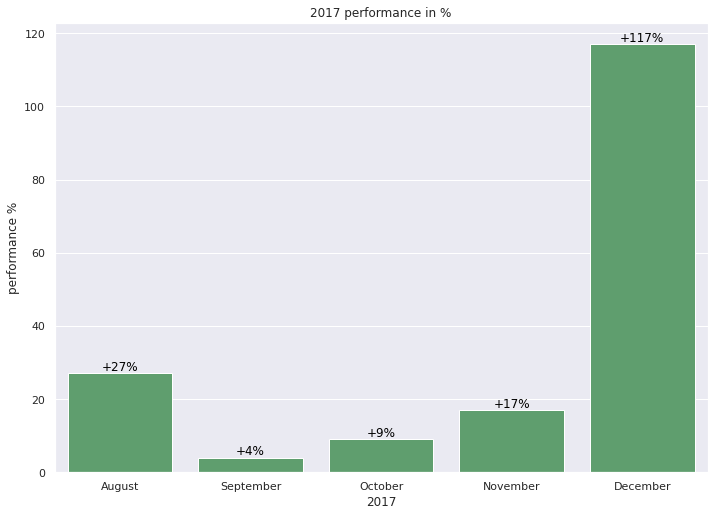

----- 2018 Performances: 242.07% -----


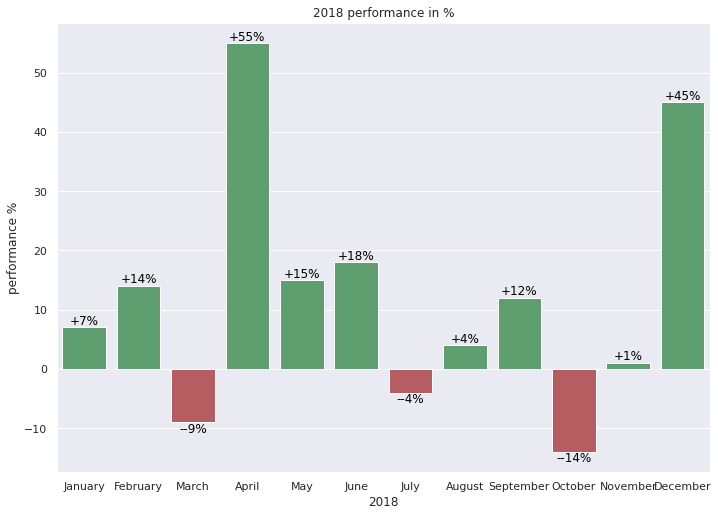

----- 2019 Performances: 176.14% -----


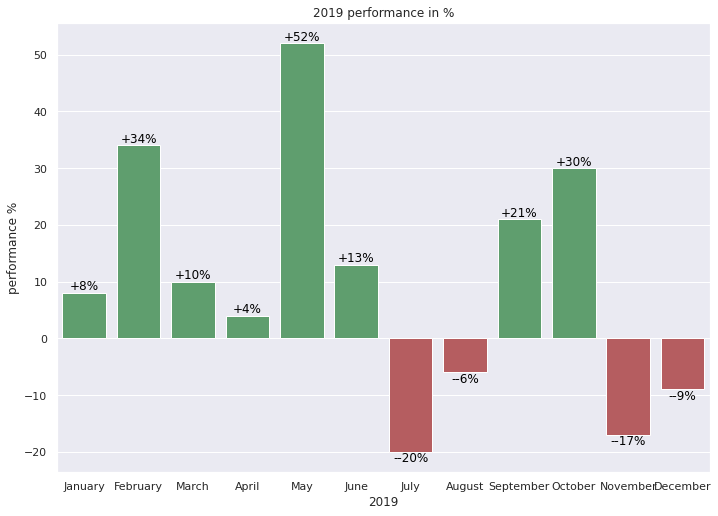

----- 2020 Performances: 335.53% -----


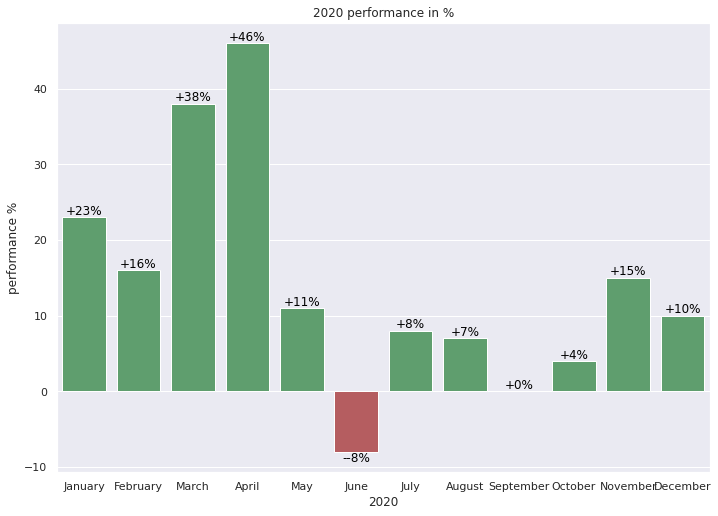

----- 2021 Performances: 203.2% -----


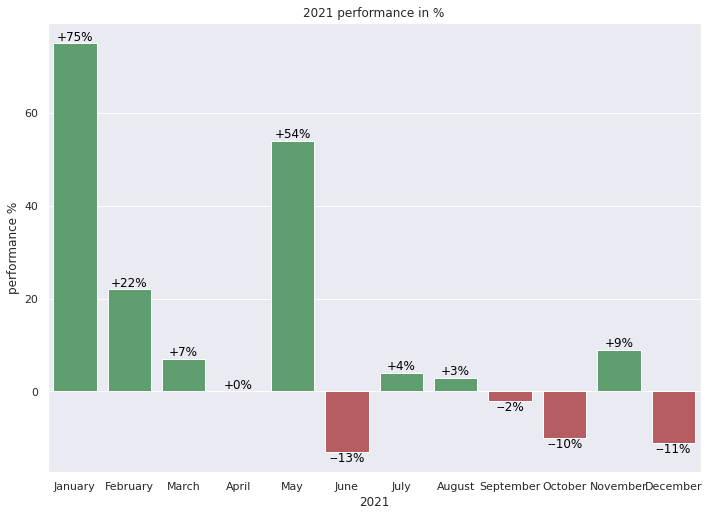

----- 2022 Performances: -6.09% -----


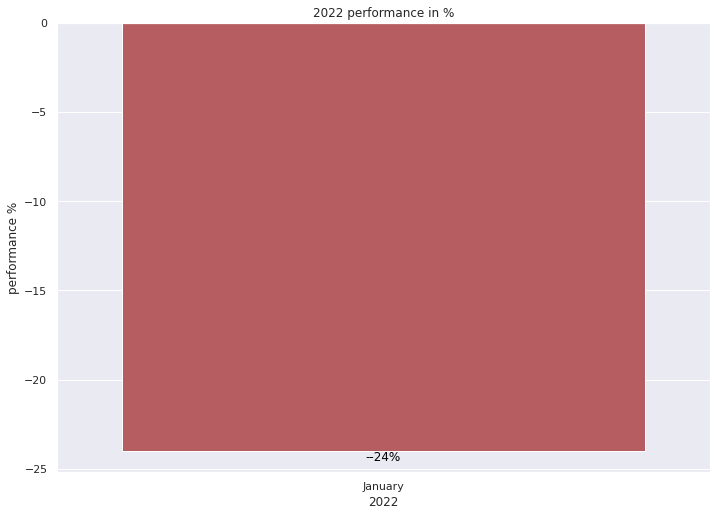

In [40]:
BTobject.plot_bar_by_month(dfTrades=dfTrades)


----- Plot -----


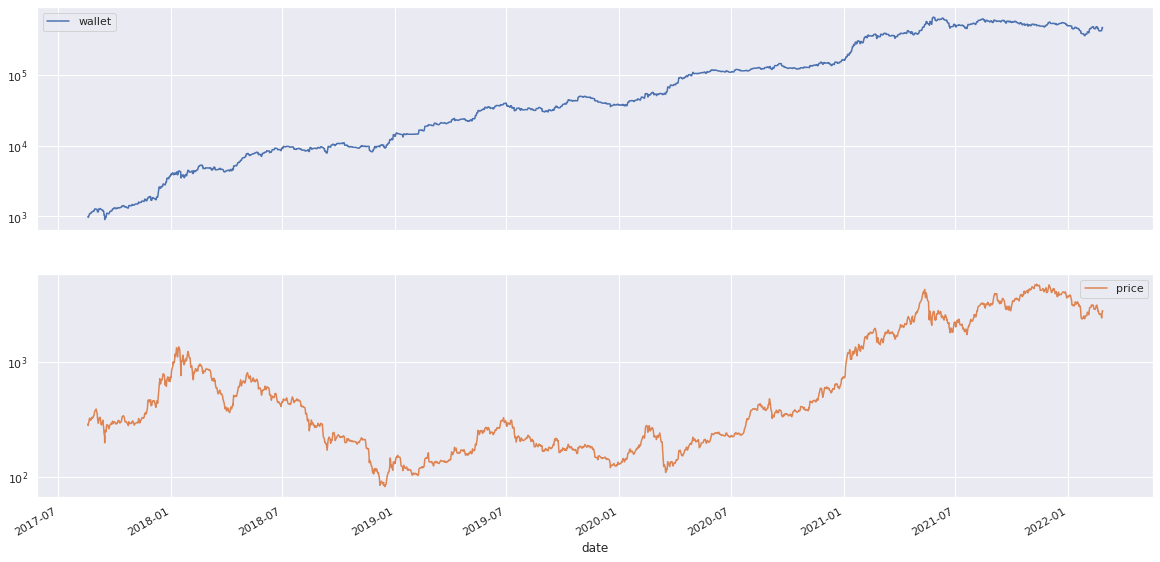

In [41]:
BTobject.plot_wallet_vs_price(dfTrades=dfTrades)